In [24]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import Normalizer

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)
tf.experimental.numpy.random.seed(42)
print(tf.__version__)

2.15.0


Import data

In [36]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/CS567/final_project/finalMergedData.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing Data

In [37]:
# Remove irrelevant columns in the dataset
remove_feature_list = ['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName', 'playDescription', 'passResult', 'playNullifiedByPenalty', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'frameId', 'collegeName',
                       'Full Name', 'Team', 'teamId']
df = df.drop(remove_feature_list, axis=1)

In [38]:
df.columns[df.isna().any()]

Index(['yardlineSide', 'passLength', 'penaltyYards', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'expectedPointsAdded'],
      dtype='object')

In [39]:
# Fill out empty entries
df['yardlineSide'].fillna('N', inplace=True)
df['passLength'].fillna(0, inplace=True)
df['penaltyYards'].fillna(0, inplace=True)
df['offenseFormation'].fillna('EMPTY', inplace=True)
df['defendersInTheBox'].fillna(0, inplace=True)
df['passProbability'].fillna(0, inplace=True)
df['expectedPointsAdded'].fillna(0, inplace=True)

### Transform textual features into numeric values

In [40]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Encode textual parameters
unique_teams = pd.unique(df[['possessionTeam', 'defensiveTeam', 'yardlineSide']].values.ravel())
label_encoder.fit(unique_teams)
df['possessionTeam'] = label_encoder.transform(df['possessionTeam'])
df['defensiveTeam'] = label_encoder.transform(df['defensiveTeam'])
df['yardlineSide'] = label_encoder.transform(df['yardlineSide'])
df['offenseFormation'] = label_encoder.fit_transform(df['offenseFormation'])
df['playDirection'] = label_encoder.fit_transform(df['playDirection'])
df['Position'] = label_encoder.fit_transform(df['Position'])

# Convert special characters
def clock_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
df['gameClock'] = df['gameClock'].apply(clock_to_min)

def height_to_cm(height):
    feet, inches = height.split('-')
    return int(feet) * 30.48 + int(inches) * 2.54
df['height_x'] = df['height_x'].apply(height_to_cm)

# Normalize each column with l2-norm


In [41]:
# # Initialize the Normalizer with L2 norm
# normalizer = Normalizer(norm='l2')

# # Apply normalization to each column
# df = pd.DataFrame(normalizer.fit_transform(df), columns=df.columns)

### Plot the correlation matrix and the covariance matrix as heatmaps

gameClock                          -0.275444
expectedPoints                     -0.049534
playDirection                       0.089147
possessionTeam                      0.118994
preSnapVisitorTeamWinProbability    0.121003
yardlineSide                        0.122615
preSnapVisitorScore                 0.129226
yearsPro                            0.130145
defensiveTeam                       0.132557
preSnapHomeScore                    0.136797
distanceToEndZone                   0.138392
preSnapHomeTeamWinProbability       0.142305
offenseFormation                    0.153667
x                                   0.154522
quarter                             0.155907
absoluteYardlineNumber              0.163878
y                                   0.167460
defendersInTheBox                   0.168024
down                                0.212286
yardsToGo                           0.234885
weight_x                            0.243819
yardlineNumber                      0.252767
overall_ra

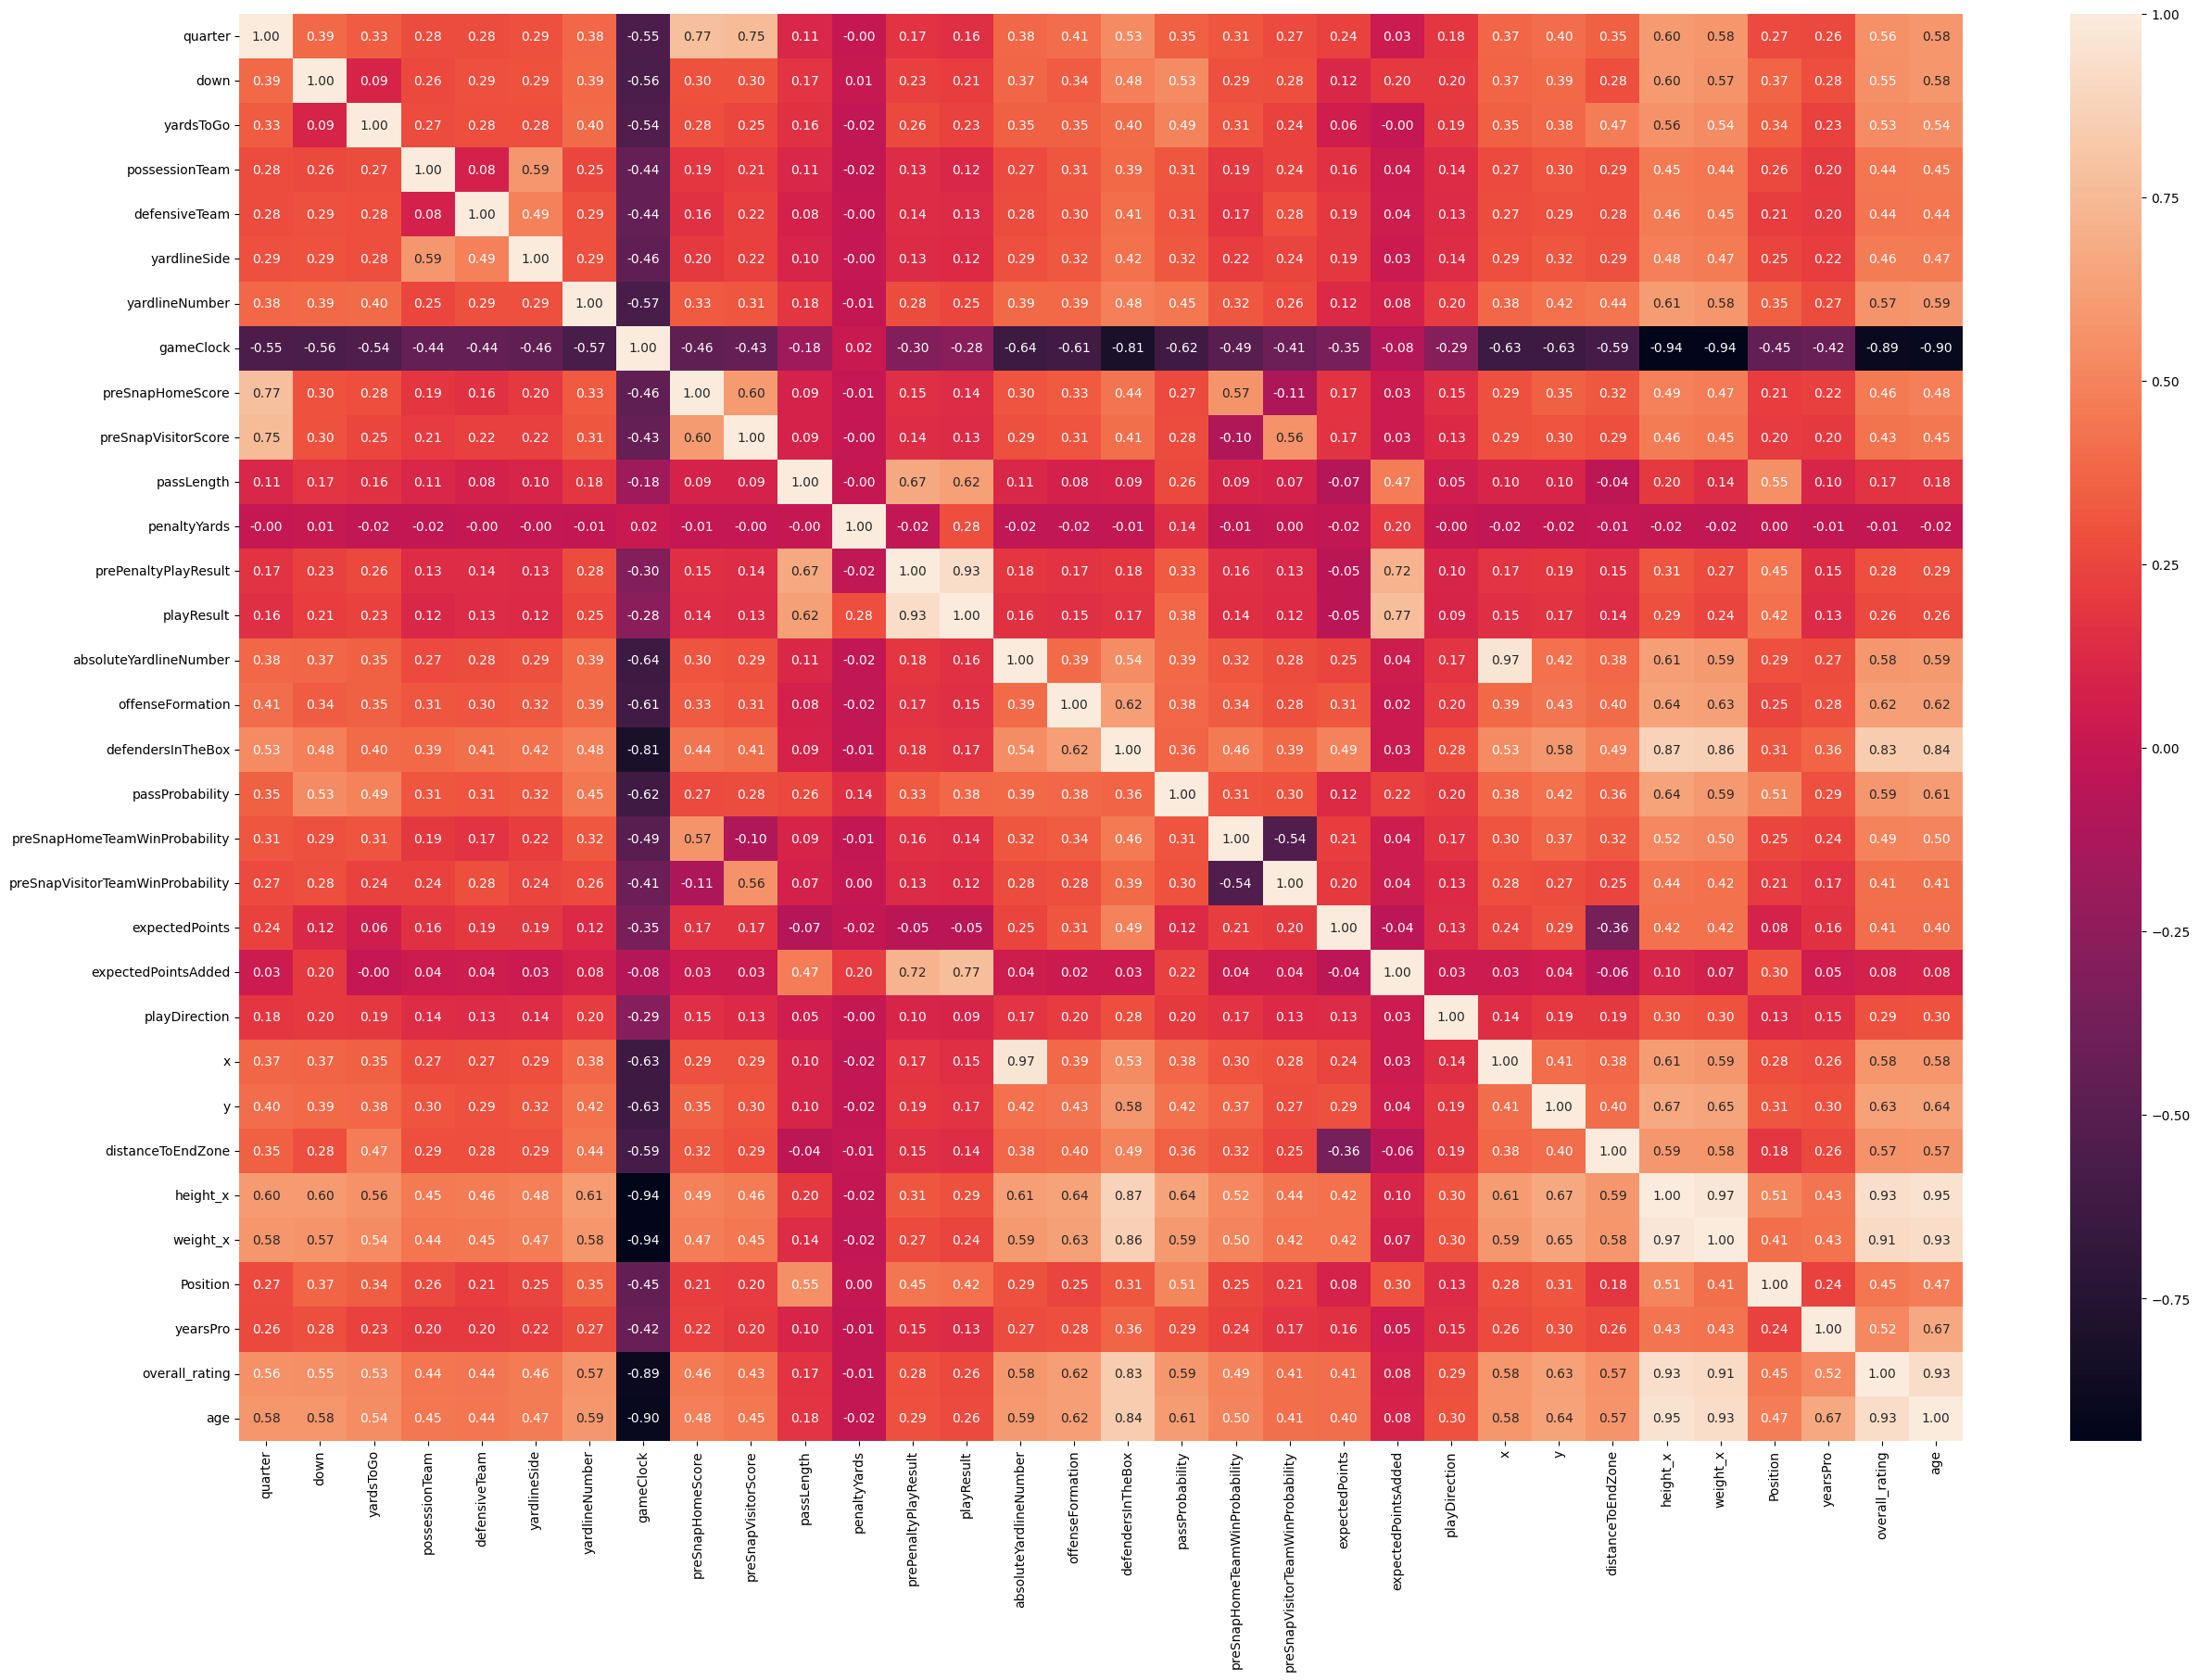

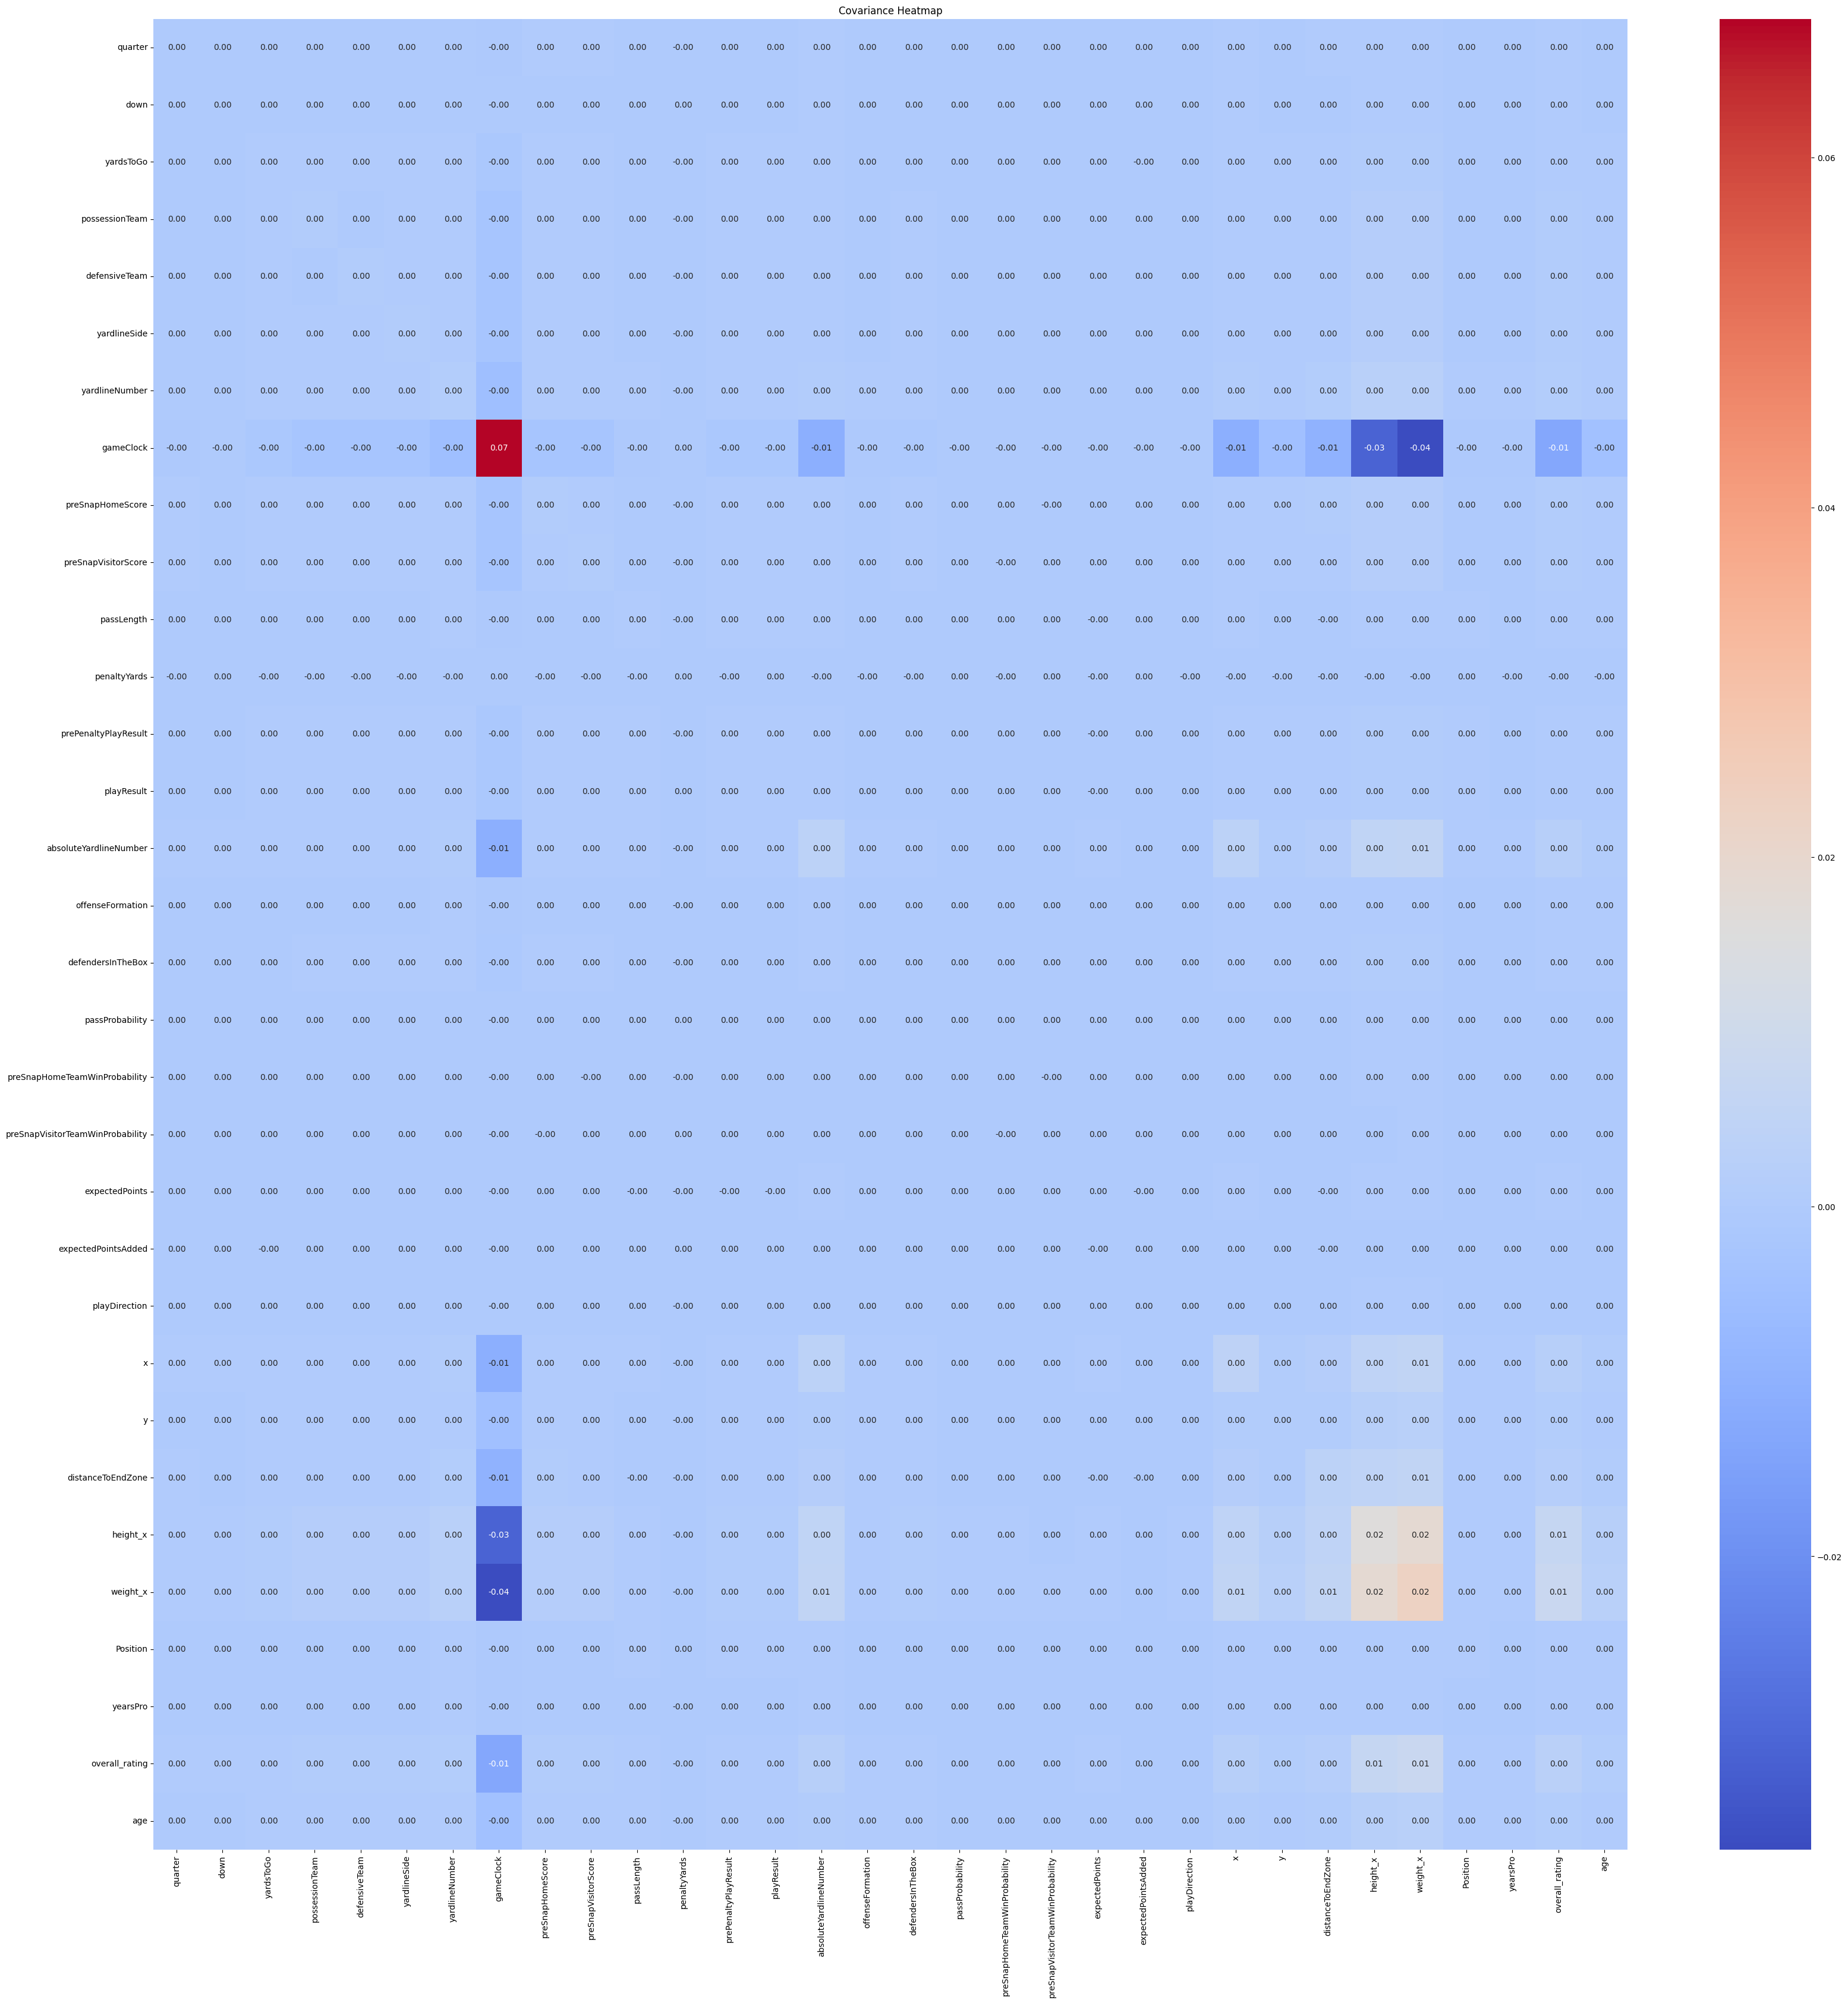

In [26]:
# Calculate correlation matrix
correlation_matrix = df.corr()
# Plot correlation heatmap
print(correlation_matrix['playResult'].sort_values())
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

# Calculate covariance matrix
covariance_matrix = df.cov()
# Plot covariance heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=df.columns, yticklabels=df.columns)
plt.title("Covariance Heatmap")
plt.show()

# Create corner plots
# sns.pairplot(df)
# plt.show()

### Split train/validation/test sets

Given the covariance heatmap and the correlation heatmap above, we can see strong dependency of the playResult on prePenaltyPlayResult, expectedPointsAdded, and passLength. We would use those three labels as the targets of our auxiliary task for each layer.

In [42]:
# Columns removed from the input features
exclude_feature_list = ['playResult', 'prePenaltyPlayResult', 'expectedPointsAdded', 'passLength']
# Input parameters
X = df.drop(exclude_feature_list, axis=1)
# Parameters to be predicted
Y = df['playResult']
# Auxiliary targets
aux_target_list = ['prePenaltyPlayResult', 'expectedPointsAdded', 'passLength']
Y_aux = df[aux_target_list]

In [43]:
# Training: X_train, Y_main_train, Y_aux_train
# Validation: X_val, Y_main_val, Y_aux_val
# Testing: X_test, Y_main_test, Y_aux_test

X_train, X_temp, Y_main_train, Y_main_temp, Y_aux_train, Y_aux_temp = train_test_split(X, Y, Y_aux, test_size=0.2, random_state=42)
X_val, X_test, Y_main_val, Y_main_test, Y_aux_val, Y_aux_test = train_test_split(X_temp, Y_main_temp, Y_aux_temp, test_size=0.5, random_state=42)

# Build the model

In [29]:
X_train.shape[1]

28

In [34]:
def create_model(num_features, init_num_neurons, n_layers, dropout_rate, act_func, optimizer, metric):
  # model structure
  inputs = Input(shape=(num_features,))
  layer = inputs
  for i in range(n_layers):
    num_neurons = init_num_neurons*0.5*i # reduce the size of layers gradually
    layer = Dense(num_neurons, activation=act_func)(layer)
    Dropout(dropout_rate)(layer)
  # Add the output layers
  main_output = Dense(1, activation='linear', name='main_output')(layer)
  outputs = [main_output]
  outputs.append(Dense(1, activation='linear', name=f'aux_output')(layer))
  # for i in range(3):
  #   outputs.append(Dense(1, activation='linear', name=f'aux_output_{i+1}')(layer))

  # Combine main and auxiliary outputs into a single model
  combined_model = Model(inputs=inputs, outputs=outputs)

  # Compile the combined model
  losses = {'main_output': 'mean_absolute_error', 'aux_output': 'mean_absolute_error'}
  loss_weights = {'main_output': 1., 'aux_output': 0.5}
  metrics={'main_output': metric, 'aux_output': metric}
  combined_model.compile(optimizer=optimizer,
                  loss=losses,
                  loss_weights=loss_weights,
                  metrics=metrics)

  return combined_model

# Define the early-stopping module
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_main_output_loss",
        # "no longer improving" being defined as "for at least 3 epochs"
        patience=5,
        verbose=1,
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
    )
]

# Train the model

In [44]:
model = create_model(num_features=X_train.shape[1], init_num_neurons=128, n_layers=5, dropout_rate=0.2, act_func='relu', optimizer='adam', metric='mean_absolute_error')

# train the model with early-stopping
model.fit(
    X_train, [Y_main_train, Y_aux_train],
    validation_data=(X_val, [Y_main_val, Y_aux_val]),
    batch_size=5, epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
1816/1816 [==============================] - 8s 4ms/step - loss: 9.4310 - main_output_loss: 7.4672 - aux_output_loss: 3.9276 - main_output_mean_absolute_error: 7.4672 - aux_output_mean_absolute_error: 3.9276 - val_loss: 8.6493 - val_main_output_loss: 6.7242 - val_aux_output_loss: 3.8500 - val_main_output_mean_absolute_error: 6.7242 - val_aux_output_mean_absolute_error: 3.8500
Epoch 2/50
1816/1816 [==============================] - 5s 3ms/step - loss: 8.5631 - main_output_loss: 6.6109 - aux_output_loss: 3.9044 - main_output_mean_absolute_error: 6.6109 - aux_output_mean_absolute_error: 3.9044 - val_loss: 8.0834 - val_main_output_loss: 6.1597 - val_aux_output_loss: 3.8474 - val_main_output_mean_absolute_error: 6.1597 - val_aux_output_mean_absolute_error: 3.8474
Epoch 3/50
1816/1816 [==============================] - 6s 3ms/step - loss: 8.1406 - main_output_loss: 6.1891 - aux_output_loss: 3.9031 - main_output_mean_absolute_error: 6.1891 - aux_output_mean_absolute_error: 3.9031 -